In [2]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator


# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [3]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

HMM training supported by protein embeddings:

In [4]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig()
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config,
                                        frozen_insertions=True,
                                        num_prior_components=1,
                                        V2_emitter=True,
                                        V2_temperature=3.)
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(3 * np.mean(data.seq_lens))) #comment out to disable cropping
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-05 17:09:43.066188: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [27 25 24 25] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730826615.476601   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826615.476804   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826615.476921   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826615.477078   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1730826616.964313   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826616.964510   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826616.964628   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826616.964776   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 14s - 295ms/step - loss: 1653471.2500 - loglik: -9.9354e+01 - prior: -1.6534e+06 - aux_loss: 0.0000e+00
Epoch 2/10
46/46 - 2s - 52ms/step - loss: 85.5287 - loglik: -8.0328e+01 - prior: -5.2010e+00 - aux_loss: 0.0000e+00
Epoch 3/10
46/46 - 2s - 51ms/step - loss: 81.9583 - loglik: -7.8346e+01 - prior: -3.6118e+00 - aux_loss: 0.0000e+00
Epoch 4/10
46/46 - 2s - 50ms/step - loss: 81.3162 - loglik: -7.8254e+01 - prior: -3.0625e+00 - aux_loss: 0.0000e+00
Epoch 5/10
46/46 - 2s - 53ms/step - loss: 80.9740 - loglik: -7.8122e+01 - prior: -2.8516e+00 - aux_loss: 0.0000e+00
Epoch 6/10
46/46 - 2s - 53ms/step - loss: 80.8205 - loglik: -7.8068e+01 - prior: -2.7521e+00 - aux_loss: 0.0000e+00
Epoch 7/10
46/46 - 2s - 53ms/step - loss: 80.7243 - loglik: -7.8022e+01 - prior: -2.7020e+00 - aux_loss: 0.0000e+00
Epoch 8/10
46/46 - 2s - 52ms/step - loss: 80.5978 - loglik: -7.7936e+01 - prior: -2.6616e+00 - aux_loss: 0.0000e+00
Epoch 9/10
46/46 - 2s - 52ms/step - loss: 80.5228 - loglik: -7.7885e+01 - pr

I0000 00:00:1730826653.692234   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826653.692456   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826653.692574   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826653.692718   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 2), (13, 2), (18, 1)]
discards model 0: []
expansions model 1: [(12, 2), (13, 3), (14, 1), (17, 1), (19, 2)]
discards model 1: []
expansions model 2: [(12, 4), (13, 2), (16, 1), (18, 2)]
discards model 2: []
expansions model 3: [(12, 2), (13, 3), (14, 1), (17, 1), (19, 2)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [32, 34, 33, 34] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730826657.373728   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826657.373914   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826657.374032   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826657.374167   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


I0000 00:00:1730826658.607639   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826658.607839   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826658.607956   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826658.608104   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 13s - 273ms/step - loss: 523928.4375 - loglik: -7.5533e+01 - prior: -5.2385e+05 - aux_loss: 0.0000e+00
Epoch 2/4
46/46 - 2s - 48ms/step - loss: 79.7900 - loglik: -7.4648e+01 - prior: -5.1423e+00 - aux_loss: 0.0000e+00
Epoch 3/4
46/46 - 2s - 47ms/step - loss: 78.2213 - loglik: -7.4892e+01 - prior: -3.3292e+00 - aux_loss: 0.0000e+00
Epoch 4/4
46/46 - 2s - 48ms/step - loss: 77.8309 - loglik: -7.5140e+01 - prior: -2.6909e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.


I0000 00:00:1730826679.168451   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826679.168657   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826679.168772   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826679.168920   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: [12]
expansions model 1: []
discards model 1: [12 15 26]
expansions model 2: []
discards model 2: [17 25]
expansions model 3: []
discards model 3: [12 18 26]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730826682.726500   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826682.726695   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826682.726812   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826682.726956   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


I0000 00:00:1730826683.965428   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826683.965611   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826683.965727   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826683.965877   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 12s - 267ms/step - loss: 90.2181 - loglik: -7.3752e+01 - prior: -1.6466e+01 - aux_loss: 0.0000e+00
Epoch 2/4
46/46 - 2s - 53ms/step - loss: 78.9096 - loglik: -7.4542e+01 - prior: -4.3675e+00 - aux_loss: 0.0000e+00
Epoch 3/4
46/46 - 2s - 53ms/step - loss: 77.7387 - loglik: -7.4975e+01 - prior: -2.7636e+00 - aux_loss: 0.0000e+00
Epoch 4/4
46/46 - 2s - 52ms/step - loss: 77.1093 - loglik: -7.4892e+01 - prior: -2.2173e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.


I0000 00:00:1730826704.423976   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826704.424181   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826704.424299   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826704.424448   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: []
expansions model 1: []
discards model 1: []
expansions model 2: []
discards model 2: []
expansions model 3: []
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730826708.464498   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826708.464736   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826708.464860   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826708.465008   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


I0000 00:00:1730826709.675884   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826709.676114   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826709.676230   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826709.676377   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 12s - 270ms/step - loss: 89.4773 - loglik: -7.3723e+01 - prior: -1.5754e+01 - aux_loss: 0.0000e+00
Epoch 2/20
46/46 - 2s - 50ms/step - loss: 78.6759 - loglik: -7.4614e+01 - prior: -4.0619e+00 - aux_loss: 0.0000e+00
Epoch 3/20
46/46 - 2s - 47ms/step - loss: 77.4409 - loglik: -7.4883e+01 - prior: -2.5580e+00 - aux_loss: 0.0000e+00
Epoch 4/20
46/46 - 2s - 47ms/step - loss: 77.1323 - loglik: -7.5097e+01 - prior: -2.0356e+00 - aux_loss: 0.0000e+00
Epoch 5/20
46/46 - 2s - 54ms/step - loss: 76.8276 - loglik: -7.4999e+01 - prior: -1.8281e+00 - aux_loss: 0.0000e+00
Epoch 6/20
46/46 - 2s - 52ms/step - loss: 76.7047 - loglik: -7.4985e+01 - prior: -1.7201e+00 - aux_loss: 0.0000e+00
Epoch 7/20
46/46 - 2s - 52ms/step - loss: 76.6114 - loglik: -7.4950e+01 - prior: -1.6618e+00 - aux_loss: 0.0000e+00
Epoch 8/20
46/46 - 2s - 48ms/step - loss: 76.6110 - loglik: -7.4999e+01 - prior: -1.6125e+00 - aux_loss: 0.0000e+00
Epoch 9/20
46/46 - 2s - 50ms/step - loss: 76.5912 - loglik: -7.5013e+01 - prior: 

I0000 00:00:1730826747.870793   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826747.870987   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826747.871118   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826747.871271   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 2.2434
Wrote file test/data/interactive.alignment.fasta
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
>l=-66.11_t=0.01
............$CD.......P........N............P.......CYN.HG..T..C....S......................L......RA...T......G..........YTCSCL....PR......YT....GEH$.......................
>l=-67.69_t=0.01
............$CD.......S........Q............P.......CRN.-G..T..Cs...L......................N......TN...T......D..........YTCACF....PG......YT....GRY$.......................
>l=-62.09_t=0.01
............$CD.......S........D............P.......CLN.GG..T..C....T......................L......RSl..D......S..........YSCACA....PG......YT....GQH$.......................
>l=-75.14_t=0.01
............$CD.......H........V............T.......CLN.GG..T..C....Q......................Lk.....TL...E......D..........YTCACA....NG......YT....GER$.......................
>l=-75.89_t=0.01
............$CD.......H........V............T.......CLN.GG..T..C....Q......................Lk.....T

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1730826753.524856   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826753.525029   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730826753.525142   75942 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

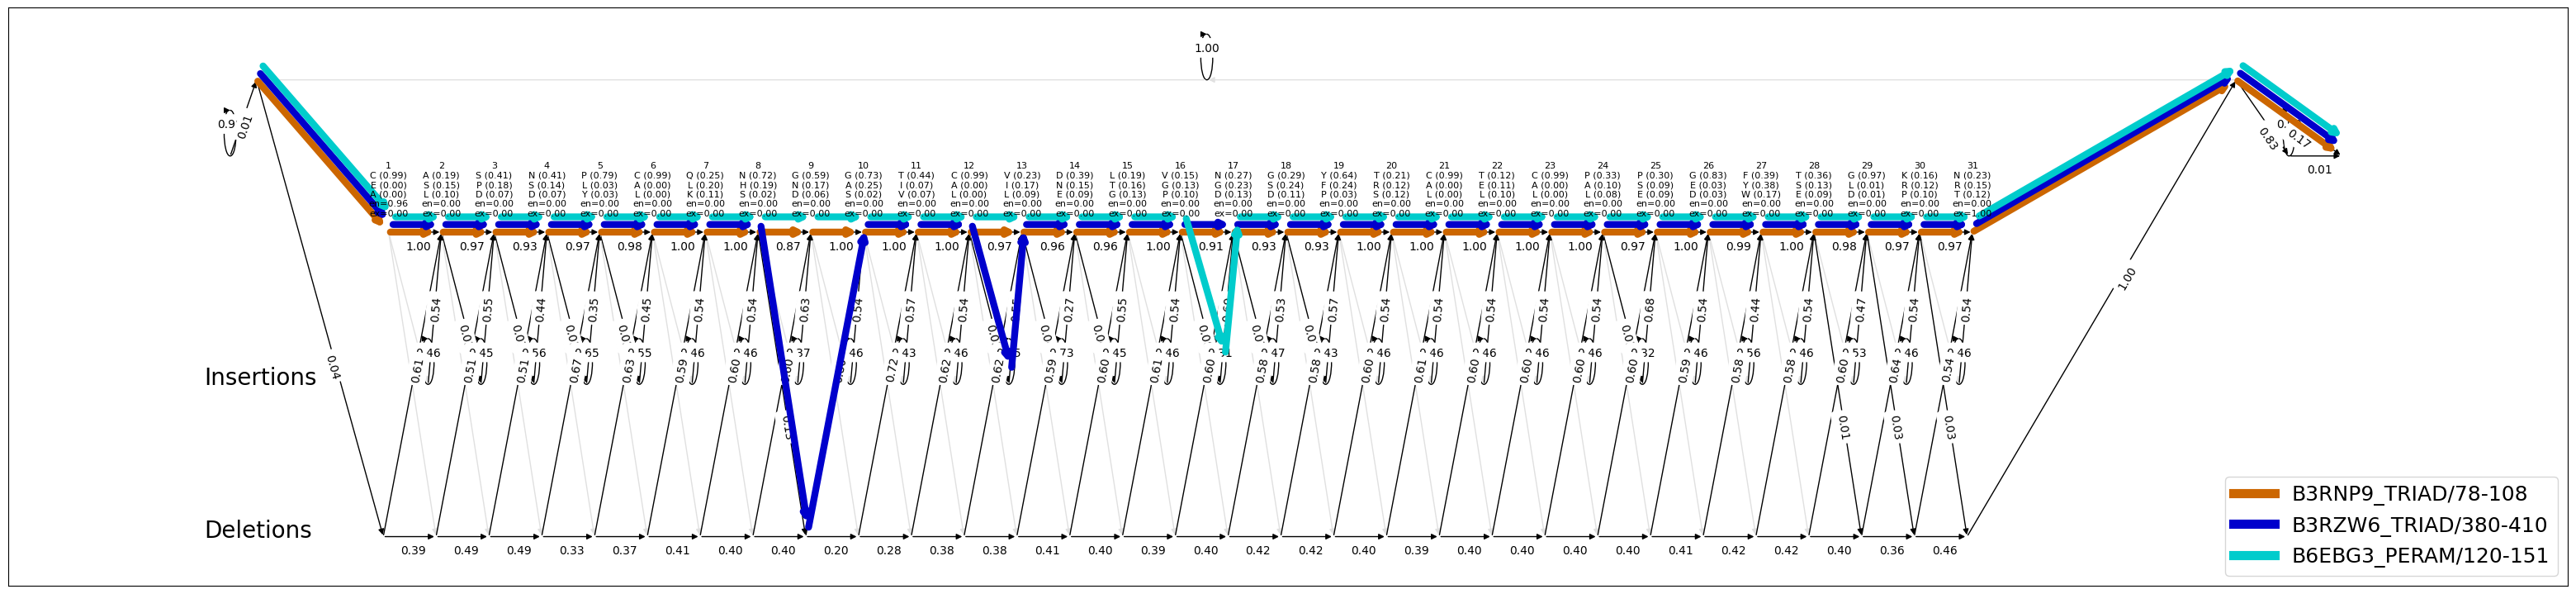

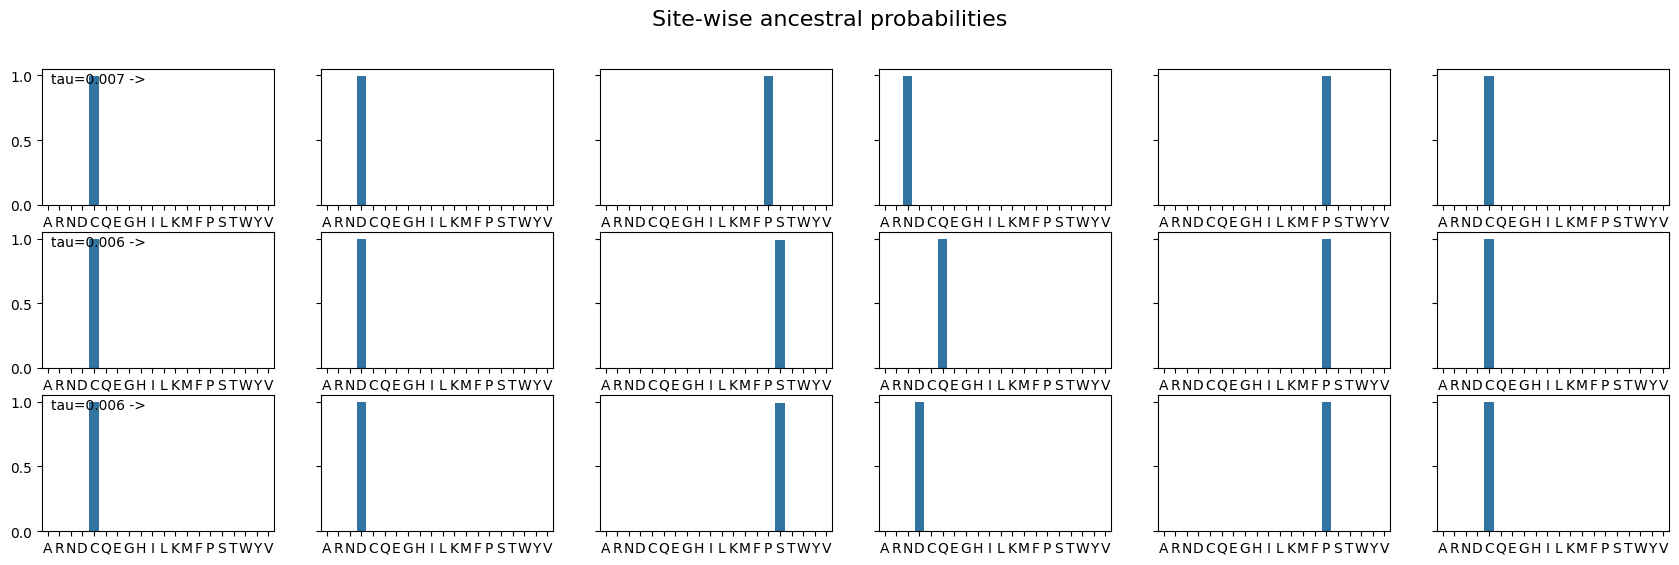

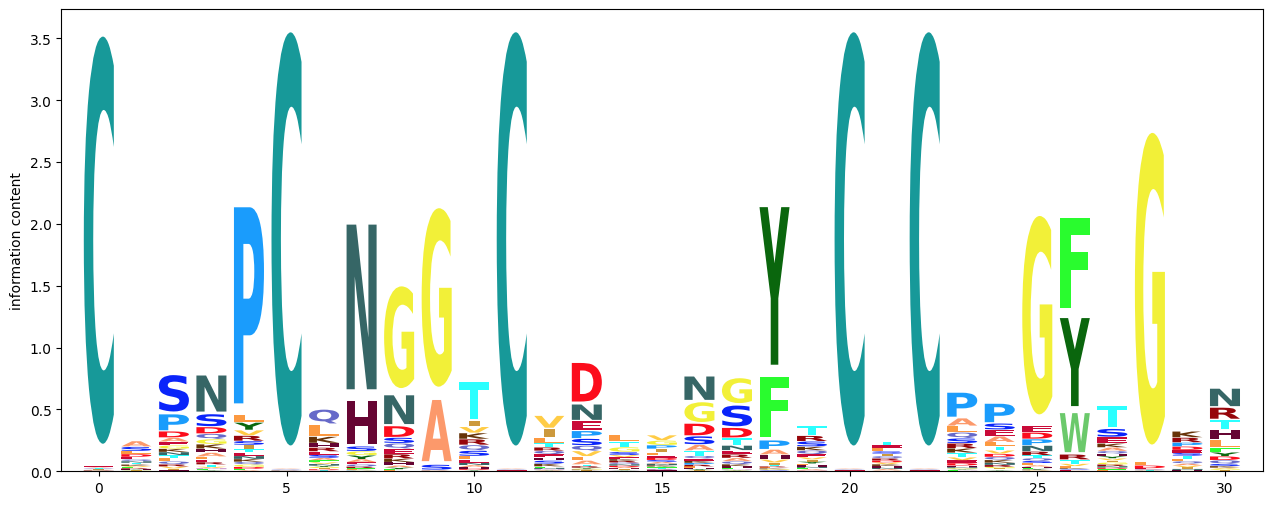

In [5]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [6]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [7]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    79.9 [100.0]   [ 5182]
